In [2]:
#Load data science libraries
import pandas
import numpy

#Load data vizualisation library
import matplotlib.pyplot as plt
import seaborn

#Change pandas display options
pandas.options.display.max_columns = None

# Load Dataset 

In [3]:
df = pandas.read_excel("../data/clean_train_dataset.xlsx")
print(df.shape)
df.head()

(891, 11)


,Survived,Pclass,Age,SibSp,Parch,Fare,C,Q,S,female,male
0,0,3,22,1,0,7,0,0,1,0,1
1,1,1,38,1,0,71,1,0,0,1,0
2,1,3,26,0,0,7,0,0,1,1,0
3,1,1,35,1,0,53,0,0,1,1,0
4,0,3,35,0,0,8,0,0,1,0,1


# Sanity Check 

In [4]:
df.isnull().sum()/len(df)

Survived    0.0
Pclass      0.0
Age         0.0
SibSp       0.0
Parch       0.0
Fare        0.0
C           0.0
Q           0.0
S           0.0
female      0.0
male        0.0
dtype: float64

# Train Test split

In [10]:
from sklearn.model_selection import train_test_split
X = df.drop("Survived",axis = 1)
Y = df.Survived
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2)
print('X_train =',X_train.shape)
print('X_test =',X_test.shape)
print('Y_train =',Y_train.shape)
print('Y_test =',Y_test.shape)

X_train = (712, 10)
X_test = (179, 10)
Y_train = (712,)
Y_test = (179,)


# Define metrics based on confusion matrix

In [16]:
from sklearn.metrics import confusion_matrix,classification_report
def get_confusion_matrix(y_test,y_pred):
    cm = confusion_matrix(y_test,y_pred)
    print(cm)
    print( classification_report(y_test,y_pred))

# Grid Search Definition

## Plotting scores

In [46]:
def plot_gridSearch_scores(results, scoring):
    plt.figure(figsize=(13, 13))
    plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
              fontsize=16)

    plt.xlabel("min_samples_split")
    plt.ylabel("Score")

    ax = plt.gca()
    ax.set_xlim(0, 500)
    ax.set_ylim(0.5, 1)

    # Get the regular numpy array from the MaskedArray
    X_axis = numpy.array(results['param_n_estimators'].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ['g', 'k']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

        best_index = numpy.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()

# Models

## Random Forest Classifier

In [21]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=1000, # Number of trees
                                  max_features=2,    # Num features considered
                                  bootstrap = False)
forest.fit(X_train,Y_train)
Y_pred = forest.predict(X_test)
get_confusion_matrix(Y_pred,Y_test)

[[92 21]
 [25 41]]
             precision    recall  f1-score   support

          0       0.79      0.81      0.80       113
          1       0.66      0.62      0.64        66

avg / total       0.74      0.74      0.74       179



In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

#Define parameters
param_grid = [
    {'n_estimators':range(2, 500, 10), 'max_features':[2,4]},
]
#define scoring
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

#launch Grid Search
grid_search = GridSearchCV(forest,param_grid,cv = 10,scoring = scoring, refit ='AUC',return_train_score=True)
grid_search.fit(X_train,Y_train)
print(grid_search.best_params_)

{'max_features': 4, 'n_estimators': 142}


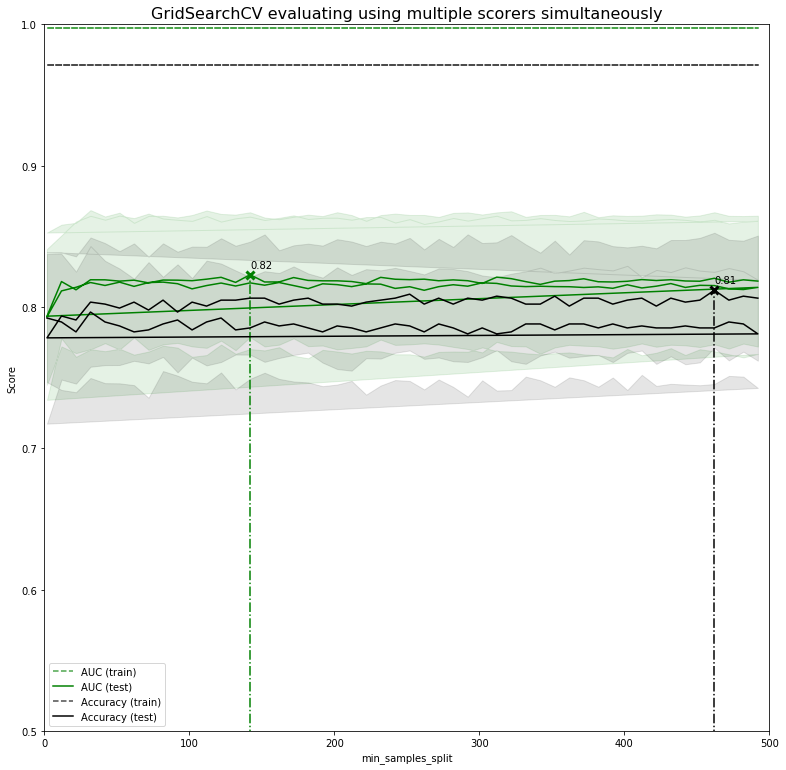

In [47]:
plot_gridSearch_scores(grid_search.cv_results_,scoring)


In [51]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=142, # Number of trees
                                  max_features=4 )   # Num features considered))
forest.fit(X_train,Y_train)
Y_pred = forest.predict(X_test)
get_confusion_matrix(Y_pred,Y_test)

[[96 20]
 [21 42]]
             precision    recall  f1-score   support

          0       0.82      0.83      0.82       116
          1       0.68      0.67      0.67        63

avg / total       0.77      0.77      0.77       179

